# Assignment 5 

### Import Necessary Libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Suppress TensorFlow unnecessary logging and force CPU-only processing
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Show only error messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable CUDA GPU visibility

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Explicitly disable GPU usage in TensorFlow

# TensorFlow and Keras imports for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Scikit-learn imports for k-fold cross-validation and metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix


### Mounting the Drive 
The assignment is done on collab as the dataset is too hight that my computer do not able to process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Images from both directories ( benign, malignant )

In [ ]:

benign_path = '/content/drive/MyDrive/Colab Notebooks/Dataset2/FNA/benign'
malignant_path = '/content/drive/MyDrive/Colab Notebooks/Dataset2/FNA/malignant'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset2/test'

img_size = (128, 128)  

# Function to load images and labels
def load_images_and_labels(path, label):
    images, labels = [], []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load benign and malignant images
benign_images, benign_labels = load_images_and_labels(benign_path, 0)
malignant_images, malignant_labels = load_images_and_labels(malignant_path, 1)


X = np.array(benign_images + malignant_images)
y = np.array(benign_labels + malignant_labels)

# Normalize the images
X = X / 255.0


### Creating CNN Model

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### K-Fold for Cross Validation

In [ ]:
# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
history_list = []

for train, val in kfold.split(X, y):
    model = create_cnn_model((img_size[0], img_size[1], 3))

    history = model.fit(X[train], y[train], epochs=10, validation_data=(X[val], y[val]), verbose=1)

    # Append history for plotting purposes
    history_list.append(history.history)

    # Evaluate on validation set
    scores = model.evaluate(X[val], y[val], verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]} - Accuracy: {scores[1]}")
    fold_no += 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6404 - loss: 0.9068 - val_accuracy: 0.8290 - val_loss: 0.4864
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8290 - loss: 0.4505 - val_accuracy: 0.8232 - val_loss: 0.4685
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8297 - loss: 0.4243 - val_accuracy: 0.8232 - val_loss: 0.4686
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8779 - loss: 0.3576 - val_accuracy: 0.8783 - val_loss: 0.3117
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8937 - loss: 0.3041 - val_accuracy: 0.8899 - val_loss: 0.3201
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8951 - loss: 0.3111 - val_accuracy: 0.8870 - val_loss: 0.3041
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9272 - loss: 0.2582 - val_accuracy: 0.8957 - val_loss: 0.2889
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9232 - loss: 0.2512 - val_accuracy: 0.8841 - val_loss:

### Ploting Accuracy and Loss for every fold

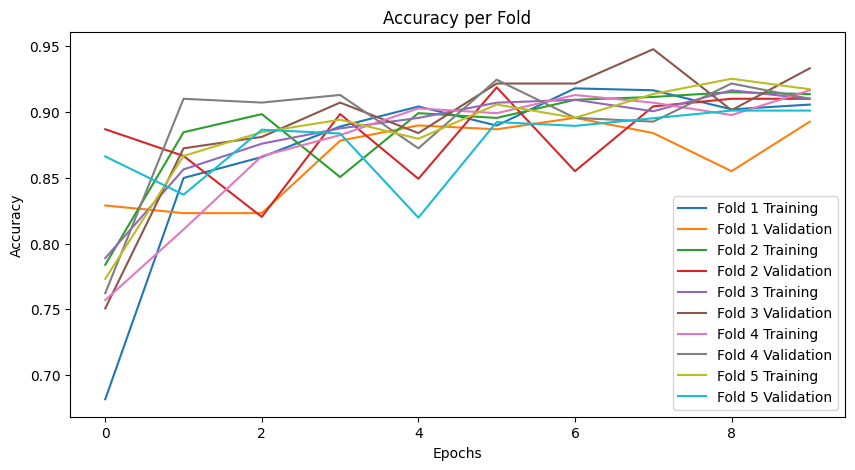

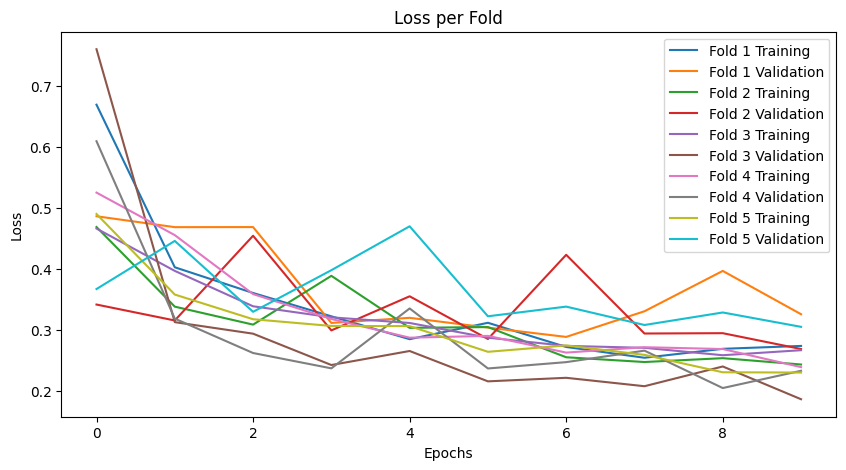

In [ ]:
# Plotting function for accuracy and loss
def plot_metrics(history_list, metric_name):
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(history_list):
        plt.plot(history[metric_name], label=f'Fold {i+1} Training')
        plt.plot(history[f'val_{metric_name}'], label=f'Fold {i+1} Validation')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} per Fold')
    plt.legend()
    plt.show()

# Plot training and validation accuracy/loss
plot_metrics(history_list, 'accuracy')
plot_metrics(history_list, 'loss')


### Testing

In [ ]:
# Load test images
test_images = []
for filename in os.listdir(test_path):
    img = cv2.imread(os.path.join(test_path, filename))
    if img is not None:
        img = cv2.resize(img, img_size)
        test_images.append(img)

test_images = np.array(test_images) / 255.0

# Predict using the last trained model from k-fold
predictions = (model.predict(test_images) > 0.5).astype("int32")

# Display predictions
for i, pred in enumerate(predictions):
    label = 'Malignant' if pred == 1 else 'Benign'
    print(f'Test image {i+1} prediction: {label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Test image 1 prediction: Benign
Test image 2 prediction: Benign
Test image 3 prediction: Malignant
Test image 4 prediction: Benign
Test image 5 prediction: Benign
Test image 6 prediction: Benign
Test image 7 prediction: Benign
Test image 8 prediction: Malignant
Test image 9 prediction: Malignant
Test image 10 prediction: Malignant
Test image 11 prediction: Malignant
Test image 12 prediction: Malignant
Test image 13 prediction: Malignant
Test image 14 prediction: Malignant


Max Accuracy - 93.51%